In [2]:
import paddle
import paddle.nn as nn

class Conv2D(nn.Layer):
    def __init__(self, kernel_size, weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0))):
        super(Conv2D, self).__init__()
        self.weight = paddle.create_parameter(shape=[kernel_size, kernel_size], dtype='float32', attr=weight_attr)

    def forward(self, X):
        u, v = self.weight.shape
        output = paddle.zeros([X.shape[0], X.shape[1]-u+1, X.shape[2]-v+1])
        for i in range(output.shape[1]):
            for j in range(output.shape[2]):
                output[:, i, j] = paddle.sum(X[:, i:i+u, j:j+v]*self.weight, axis=[1,2])
        return output

paddle.seed(100)
inputs = paddle.randn(shape=[2, 3, 3])
conv2d = Conv2D(kernel_size=2)
outputs = conv2d(inputs)
print("input: {}, \noutput: {}".format(inputs, outputs))

W0615 03:24:54.101513 42770 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0615 03:24:54.102866 42770 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


input: Tensor(shape=[2, 3, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[[ 1.43499076, -1.49816811, -0.80991703],
         [-1.17841148, -2.64788008, -0.02325319],
         [-1.37605178,  1.15511811, -1.09137952]],

        [[-0.38226849, -0.34601274,  0.32342353],
         [ 1.54802513,  1.83054280, -0.42103252],
         [ 0.33243179,  1.62033129, -0.26160610]]]), 
output: Tensor(shape=[2, 2, 2], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[-3.88946891, -4.97921848],
         [-4.04722500, -2.60739470]],

        [[ 2.65028667,  1.38692105],
         [ 5.33133125,  2.76823545]]])


In [3]:
class Conv2D(nn.Layer):
    def __init__(self, kernel_size, stride=1, padding=0, weight_attr=paddle.ParamAttr(initializer=nn.initializer.Constant(value=1.0))):
        super(Conv2D, self).__init__()
        self.weight = paddle.create_parameter(shape=[kernel_size, kernel_size], dtype='float32', attr=weight_attr)
        self.stride = stride
        self.padding = padding

    def forward(self, X):
        new_X = paddle.zeros([X.shape[0], X.shape[1]+2*self.padding, X.shape[2]+2*self.padding])
        new_X[:, self.padding:X.shape[1]+self.padding, self.padding:X.shape[2]+self.padding] = X
        u, v = self.weight.shape
        output_w = (new_X.shape[1] - u) // self.stride + 1
        output_h = (new_X.shape[2] - v) // self.stride + 1
        output = paddle.zeros([X.shape[0], output_w, output_h])
        for i in range(0, output.shape[1]):
            for j in range(0, output.shape[2]):
                output[:, i, j] = paddle.sum(new_X[:, self.stride*i:self.stride*i+u, self.stride*j:self.stride*j+v]*self.weight, axis=[1,2])
        return output

inputs = paddle.randn(shape=[2, 8, 8])
conv2d_padding = Conv2D(kernel_size=3, padding=1)
outputs = conv2d_padding(inputs)
print("input: {}, \noutput: {}".format(inputs.shape, outputs.shape))
conv2d_stride = Conv2D(kernel_size=3, stride=2, padding=1)
outputs = conv2d_stride(inputs)
print("input: {}, \noutput: {}".format(inputs.shape, outputs.shape))

input: [2, 8, 8], 
output: [2, 8, 8]
input: [2, 8, 8], 
output: [2, 4, 4]


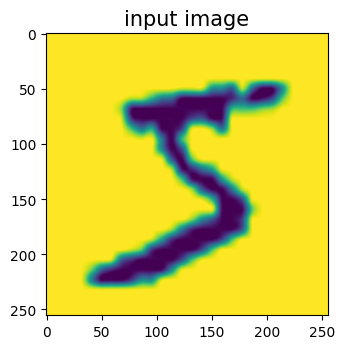

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np 

img = Image.open('0.png').resize((256, 256))
plt.figure(figsize=(8, 4))
f = plt.subplot(121)
f.set_title('input image', fontsize=15)
plt.imshow(img)

In [5]:
w = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32')
conv = Conv2D(kernel_size=3, stride=1, padding=0, weight_attr=paddle.ParamAttr(initializer=nn.initializer.Assign(value=w)))
inputs = np.array(img).astype('float32')
inputs = paddle.to_tensor(inputs)
inputs = paddle.unsqueeze(inputs, axis=0)
outputs = conv(inputs)
print(outputs)

Tensor(shape=[1, 254, 254], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]])


In [ ]:
outputs_cpu = outputs.cpu()
outputs_np = outputs_cpu.numpy()
print(outputs_np)

In [ ]:
f = plt.subplot(122)
f.set_title('output feature map', fontsize=15)
plt.imshow(outputs_np.squeeze(), cmap='gray')
plt.show()